In this notebook, a lightweight pretrained model [albert](https://arxiv.org/abs/1909.11942) is finetuned on cola dataset, using three semisupervised training method: (i) [PiModel](https://arxiv.org/abs/1610.02242), (ii) [Temporal Ensembling](https://arxiv.org/abs/1610.02242) and (iii) [Co-Training](https://arxiv.org/abs/1610.02242) using ssfinetuning package.


We will perform three steps for each model:

1. Installation
2. Training 
3. Plotting the results using ssfinetuning plotter.



In [7]:
!pip3 install ssfinetuning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import torch
from datasets import load_dataset, load_metric
from ssfinetuning import train_with_ssl

Downloading cola dataset via HuggingFace's [datasets](https://github.com/huggingface/datasets) library.

In [11]:
dataset = load_dataset("glue", "cola")
metric = load_metric('glue', "cola")

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/cola/1.0.0/7c99657241149a24692c402a5c3f34d4c9f1df5ac2e4c3759fadea38f6cb29c4. Subsequent calls will reuse this data.


Setting the seed value for reproducible results.

In [12]:
torch.manual_seed(970)
torch.cuda.manual_seed_all(970)

In [13]:
display(dataset)
print(type(dataset))


DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 8551
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1043
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1063
    })
})

<class 'datasets.dataset_dict.DatasetDict'>


# FineTuning with PiModel

## Options chosen for training in this example.

1. labeled_fraction: This is the list which divides the dataset into different labeled fractions mentioned as the list elements. For example,
if a list of `labeled_fraction` is set as below, the function `train_with_ssl` will first keep the 15% of data as labeled and consider the rest as unlabeled and apply all the combinations of hyperparmeters to obtain the results. Then, it will do the same by keeping 35% of the labels and so on.  

2. use_sup: This is whether the trainer should first train a supervised model and then use that trained model as an starting point for the ssl training.

3. dataset: Huggingface dataset.

4. model_name: NLP transformers model name as used by huggingface library. See this [page](https://huggingface.co/transformers/pretrained_models.html) for more information.

5. arg_ta = `transformers.TrainingArguments`, check this [page](https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments) for information. If using `train_with_ssl` then, there are default values setup in `default_args` module. These values are similar to this [notebook](https://github.com/huggingface/notebooks/blob/master/examples/text_classification.ipynb) since cola dataset has been used here. If you would like to keep all the other arguments [same](https://github.com/huggingface/notebooks/blob/master/examples/text_classification.ipynb) as this notebook but changed only few, it could be changed with using arg_ta as dictionary and changing that specific argument like below. Otherwise you can also a prepare whole new TrainingArguments object. 

6. arg_ta_sup: Similar to `arg_ta`, but for supervised model, if `use_sup` or `run_sup` has been enabled.

7. ssl_model_type: Semisupervised model type.

**`unsup_hp`**:

This is a dictionary of hyperparameter that you would like test you ssl model against. For example, in the case of PiModel the choices could be:

- **w_ramprate**: linear rate at which the unsupervised weight would be increased from the initial value.
- **update_weights_steps:** interval steps after which unsupervised weight
would be updated by the w_ramprate etc.
 
Please look at [`PiModel`](https://ssfinetuning.readthedocs.io/en/latest/ssfinetuning.html#ssfinetuning.models.PiModel) or [`TrainerWithUWScheduler`](https://ssfinetuning.readthedocs.io/en/latest/ssfinetuning.html#ssfinetuning.trainer_util.TrainerWithUWScheduler) documentation for more information. 
In this example we only use vary `w_ramprate`. 

In [14]:
sup_stats, stats_pi = train_with_ssl(labeled_fraction=[0.15, 0.35, 0.5], use_sup=True, dataset = dataset, 
                                     model_name="albert-base-v2", args_ta={'no_cuda' :False}, args_ta_sup={'no_cuda':False},
                                     ssl_model_type="PiModel", unsup_hp={'w_ramprate':[0.01,0.1]})

Parameter 'function'=<function encode.<locals>.preprocess_function at 0x7f8de4ace8c0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

{'eval_loss': 0.5502092838287354, 'eval_matthews_correlation': 0.30666950079089705, 'eval_runtime': 1.3855, 'eval_samples_per_second': 752.774, 'epoch': 1.0}
{'eval_loss': 0.5812187790870667, 'eval_matthews_correlation': 0.3509239643825122, 'eval_runtime': 1.3962, 'eval_samples_per_second': 747.007, 'epoch': 2.0}
{'eval_loss': 0.7679703235626221, 'eval_matthews_correlation': 0.3803455186873534, 'eval_runtime': 1.3819, 'eval_samples_per_second': 754.766, 'epoch': 3.0}
{'eval_loss': 0.6659916043281555, 'eval_matthews_correlation': 0.4187675995559273, 'eval_runtime': 1.4122, 'eval_samples_per_second': 738.561, 'epoch': 4.0}
{'eval_loss': 0.9924721121788025, 'eval_matthews_correlation': 0.4277276124684456, 'eval_runtime': 1.4051, 'eval_samples_per_second': 742.273, 'epoch': 5.0}
{'eval_loss': 1.22859525680542, 'eval_matthews_correlation': 0.4336331136498832, 'eval_runtime': 1.4396, 'eval_samples_per_second': 724.491, 'epoch': 6.0}
{'loss': 0.3088, 'learning_rate': 7.500000000000001e-06, 'e

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

{'eval_loss': 0.5668179392814636, 'eval_matthews_correlation': 0.23673476188085057, 'eval_runtime': 1.5671, 'eval_samples_per_second': 665.548, 'epoch': 1.0}
{'eval_loss': 0.5494748950004578, 'eval_matthews_correlation': 0.4227852814134363, 'eval_runtime': 1.5741, 'eval_samples_per_second': 662.605, 'epoch': 2.0}
{'loss': 0.4653, 'learning_rate': 1.4652406417112302e-05, 'epoch': 2.67}
{'eval_loss': 0.6202734112739563, 'eval_matthews_correlation': 0.3993857716822706, 'eval_runtime': 1.5489, 'eval_samples_per_second': 673.371, 'epoch': 3.0}
{'eval_loss': 0.7320840358734131, 'eval_matthews_correlation': 0.45274767660246595, 'eval_runtime': 1.5655, 'eval_samples_per_second': 666.255, 'epoch': 4.0}
{'eval_loss': 1.1018143892288208, 'eval_matthews_correlation': 0.4134570857201349, 'eval_runtime': 1.5536, 'eval_samples_per_second': 671.362, 'epoch': 5.0}
{'loss': 0.2226, 'learning_rate': 9.3048128342246e-06, 'epoch': 5.35}
{'eval_loss': 1.014625072479248, 'eval_matthews_correlation': 0.394210

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/glue/cola/1.0.0/7c99657241149a24692c402a5c3f34d4c9f1df5ac2e4c3759fadea38f6cb29c4/cache-cbbac8d05c5f4f38.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/glue/cola/1.0.0/7c99657241149a24692c402a5c3f34d4c9f1df5ac2e4c3759fadea38f6cb29c4/cache-1c80317fa3b1799d.arrow
Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequence

{'eval_loss': 0.5513008832931519, 'eval_matthews_correlation': 0.2883439103089388, 'eval_runtime': 1.5699, 'eval_samples_per_second': 664.394, 'epoch': 1.0}
{'loss': 0.5226, 'learning_rate': 1.6254681647940076e-05, 'epoch': 1.87}
{'eval_loss': 0.496294766664505, 'eval_matthews_correlation': 0.42239354524181305, 'eval_runtime': 1.5647, 'eval_samples_per_second': 666.584, 'epoch': 2.0}
{'eval_loss': 0.5876179337501526, 'eval_matthews_correlation': 0.44158667809088026, 'eval_runtime': 1.5408, 'eval_samples_per_second': 676.908, 'epoch': 3.0}
{'loss': 0.2756, 'learning_rate': 1.250936329588015e-05, 'epoch': 3.75}
{'eval_loss': 0.8144561052322388, 'eval_matthews_correlation': 0.4797446434500675, 'eval_runtime': 1.5581, 'eval_samples_per_second': 669.421, 'epoch': 4.0}
{'eval_loss': 0.9899852275848389, 'eval_matthews_correlation': 0.4560008980132594, 'eval_runtime': 1.5774, 'eval_samples_per_second': 661.224, 'epoch': 5.0}
{'loss': 0.1522, 'learning_rate': 8.764044943820226e-06, 'epoch': 5.6

This is very time consuming step so just showing results from saved files alongwith correct steps to be used.

In [15]:
from ssfinetuning import plotting_utils
from ssfinetuning.dataset_utils import dic_to_pandas

**You can read more about `plotting_utils` module [here](https://ssfinetuning.readthedocs.io/en/latest/ssfinetuning.html?highlight=plotting#module-ssfinetuning.plotting_utils)**

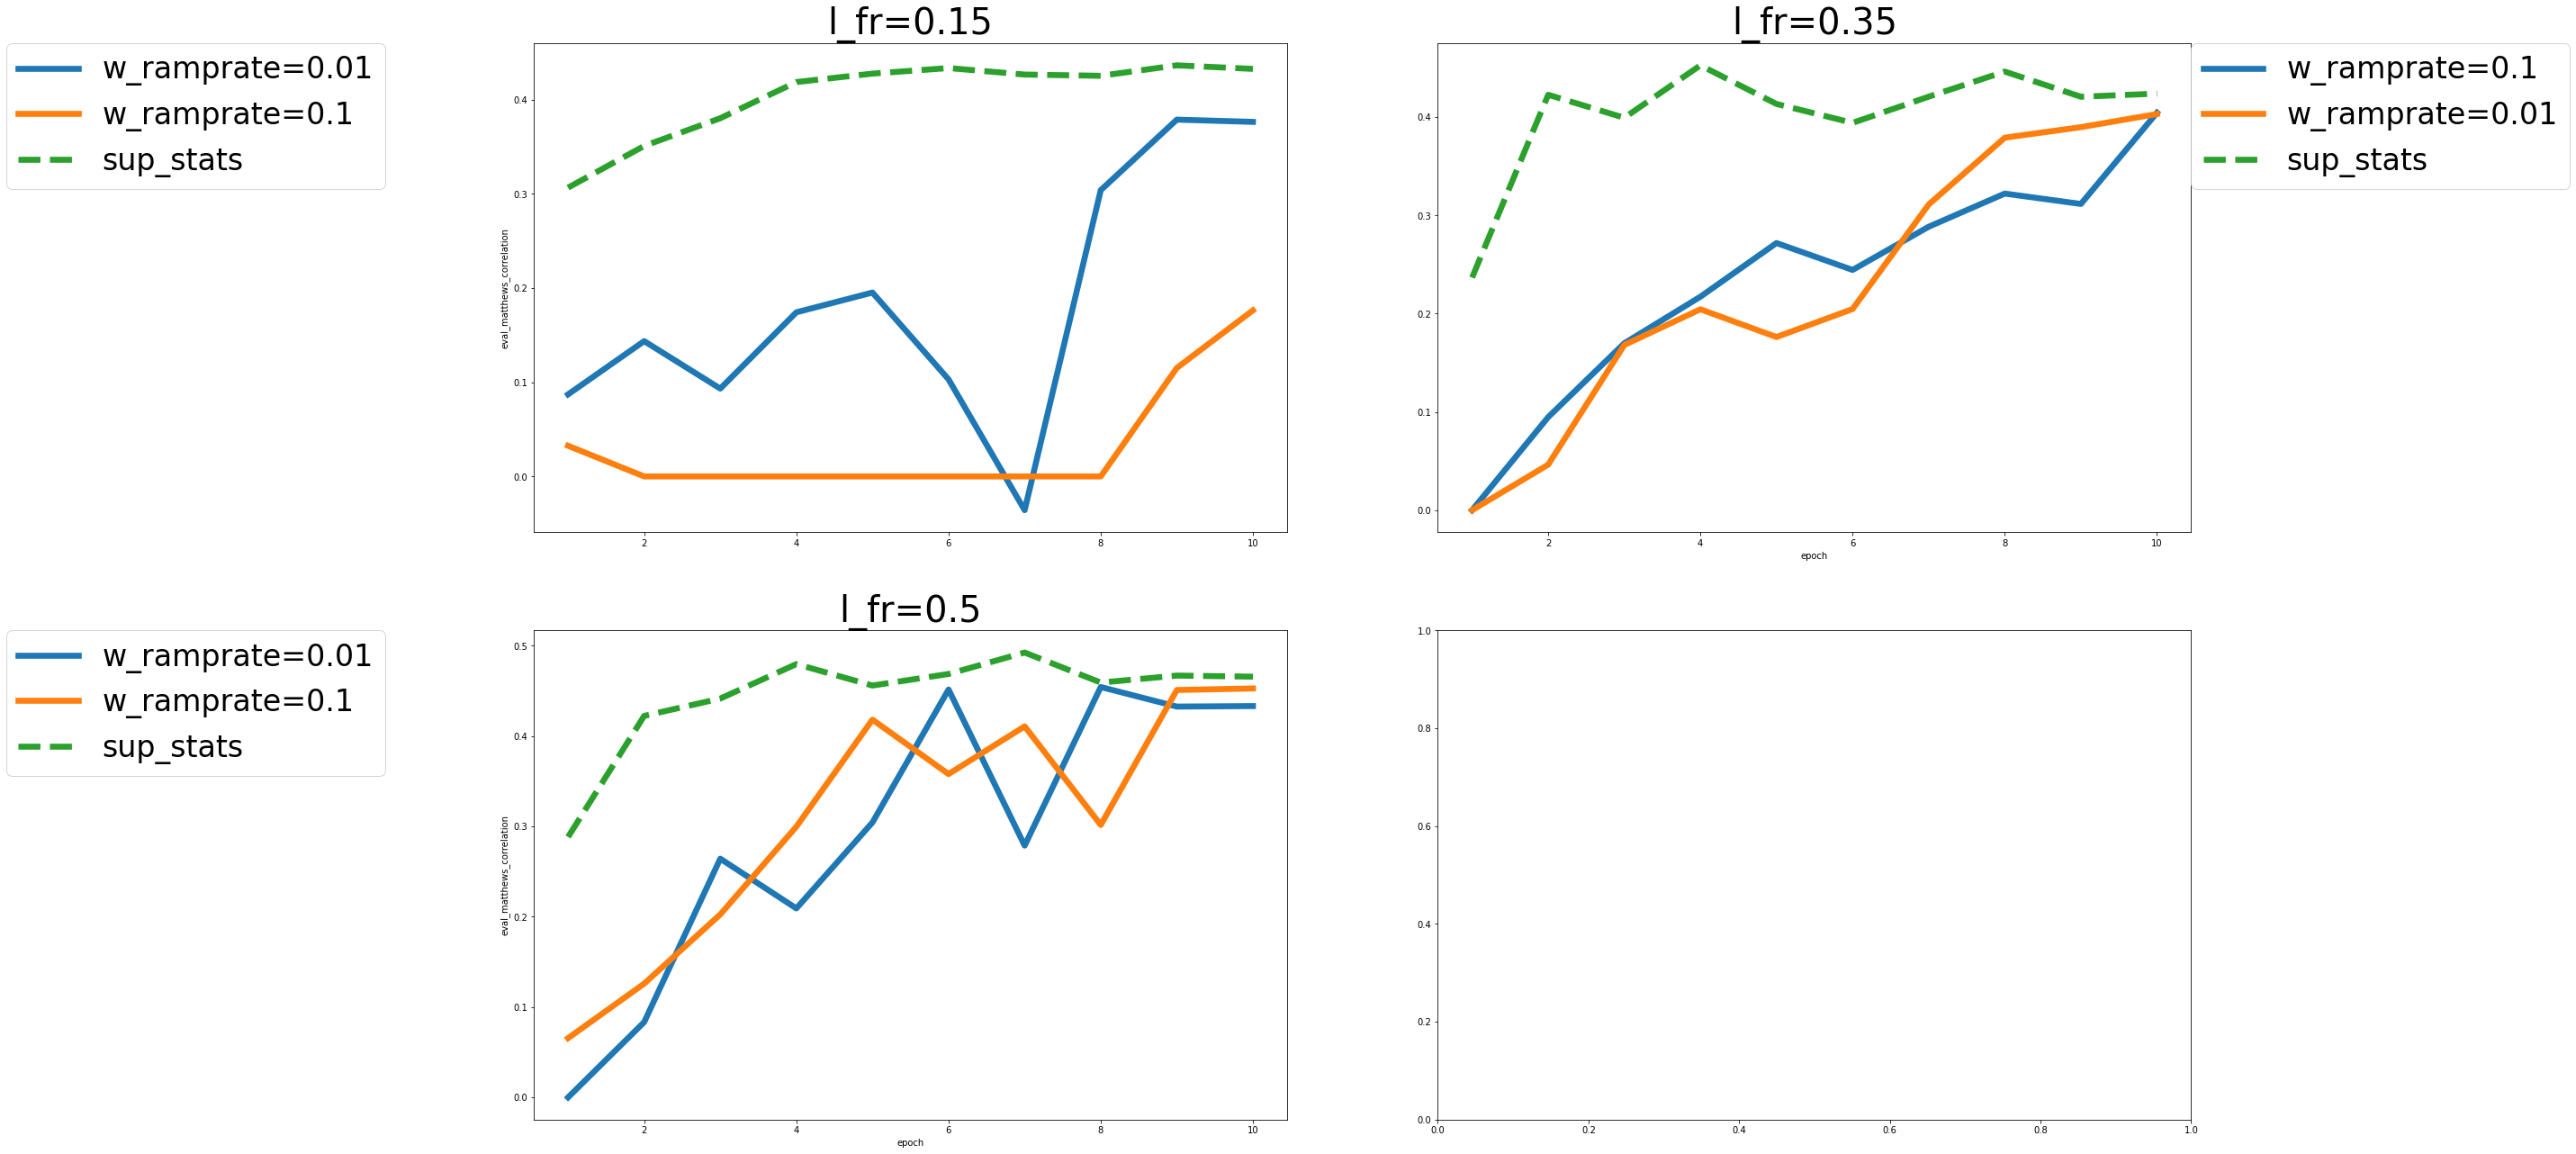

In [16]:
plotting_utils.sort_and_plot(dis_col='l_fr', data=dic_to_pandas(stats_pi), data_to_compare = dic_to_pandas(sup_stats),
                             y_axis_col='eval_matthews_correlation', cols_to_find=["w_ramprate"])

# Finetuning with TemporalEnsemble model

At this point, the colab notebook has been factory reset with reruns of first 4 cells. So to reproduce the same results, one might do that. 

In this case, we only check with one labeled fraction with checking out another hyperparamter important for this ssl model, `alpha`.

You can read more about this in hyperparameter in [documentation](https://ssfinetuning.readthedocs.io/en/latest/ssfinetuning.html?highlight=alpha#ssfinetuning.models.TemporalEnsembleModel) or in the [original paper](https://arxiv.org/pdf/1610.02242.pdf). 

In [18]:
sup_stats, stats_te = train_with_ssl([0.1], use_sup=True, dataset = dataset,model_name="albert-base-v2", 
                                     args_ta={'no_cuda' :False, 'learning_rate':5e-6}, args_ta_sup={'no_cuda':False},
                                     ssl_model_type="TemporalEnsemble", unsup_hp={'w_ramprate':[0.01,0.1], 'alpha':[0.3,0.6,0.9]})

Loading cached processed dataset at /root/.cache/huggingface/datasets/glue/cola/1.0.0/7c99657241149a24692c402a5c3f34d4c9f1df5ac2e4c3759fadea38f6cb29c4/cache-1c80317fa3b1799d.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/glue/cola/1.0.0/7c99657241149a24692c402a5c3f34d4c9f1df5ac2e4c3759fadea38f6cb29c4/cache-bdd640fb06671ad1.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/glue/cola/1.0.0/7c99657241149a24692c402a5c3f34d4c9f1df5ac2e4c3759fadea38f6cb29c4/cache-3eb13b9046685257.arrow
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/glue/cola/1.0.0/7c99657241149a24692c402a5c3f34d4c9f1df5ac2e4c3759fadea38f6cb29c4/cache-893114c65bcbfa9b.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/glue/cola/1.0.0/7c99657241149a24692c402a5c3f34d4c9f1df5ac2e4c3759fadea38f6cb29c4/cache-23b8c1e9392456de.arrow
Some weights of the model checkpoint at albert-base-v2 were not used when initializing Al

RuntimeError: ignored

In [ ]:
plotting_utils.sort_and_plot(dis_col='l_fr', data=dic_to_pandas(stats_te), data_to_compare=dic_to_pandas(sup_stats),
                             y_axis_col='eval_matthews_correlation', cols_to_find=["w_ramprate",'alpha'])

# Finetuning with CoTrain

Continuing with the factory reset. 
## Changed options:

- num_train_epochs: In this case, we change number of training epochs to 5.
- learning_rate: learning rate is set 1e-5 instead of 2e-5 for default case.

**`usup_hp`**
- **`p_threshold`**: Threshold probability for considering exchange between models.
- **`epoch_per_cotrain`**:Number of epochs to pass through training data while going through one iteration of cotraining. 

You can read more about this in the [`TrainerForCoTraining`](https://ssfinetuning.readthedocs.io/en/latest/ssfinetuning.html?highlight=trainerfor#ssfinetuning.trainer_util.TrainerForCoTraining) or [`CoTrain`](https://ssfinetuning.readthedocs.io/en/latest/ssfinetuning.html?highlight=CoTrain#ssfinetuning.models.CoTrain) documentation. 

In [ ]:
sup_stats, stats_co = train_with_ssl([0.1, 0.5], model_name="albert-base-v2", use_sup=True, dataset = dataset, 
                                  args_ta_sup={'no_cuda':False, 'num_train_epochs':5, 'learning_rate':1e-5},args_ta={'no_cuda':False, 'learning_rate':1e-5}, 
                                  ssl_model_type="CoTrain", unsup_hp={'p_threshold':[0.2, 0.4, 0.85], 'epoch_per_cotrain':[5]})

In [ ]:
plotting_utils.sort_and_plot(dis_col='l_fr', data=dic_to_pandas(stats_co), data_to_compare=dic_to_pandas(sup_stats), 
                             y_axis_col='eval_matthews_correlation', cols_to_find=['epoch_per_cotrain', 'p_threshold'])